In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import os

# Load the model architecture and weights

In [18]:
if os.path.isfile('best_robnet.h5'):
    print('loading RobNet')
    model = load_model('best_robnet.h5') # retrain to get best_robnet_weights_rgb.h5
else:
    model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=num_val_samples//batch_size,
        callbacks=[save_best_checkpoint])


loading RobNet
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [192]:
%pylab inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from PIL import Image
import random

Populating the interactive namespace from numpy and matplotlib


/home/rcdc008/anaconda3/envs/mp/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


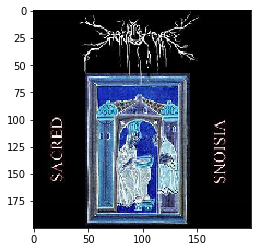

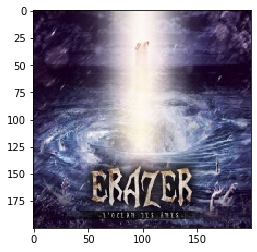

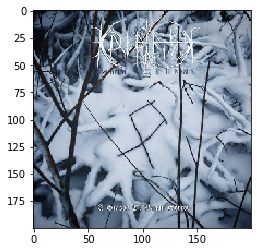

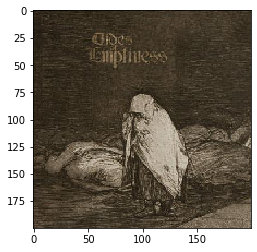

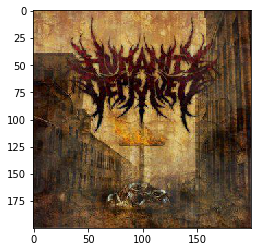

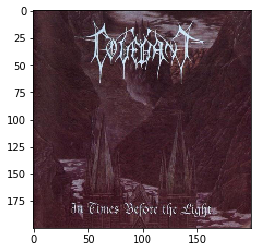

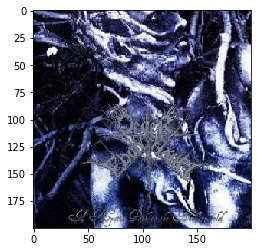

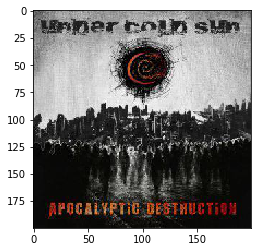

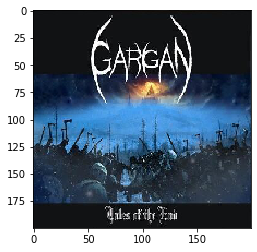

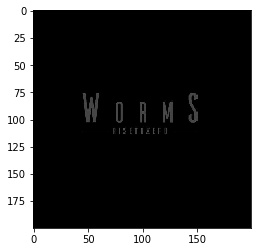

[0, 1, 0, 0, 1, 0, 0, 1, 1, 1]


In [229]:
demo_paths = []
demo_paths.append('data/validation/black/black_46754.jpg')
demo_paths.append('data/validation/black/black_4474.jpg')
demo_paths.append('data/validation/black/black_44036.jpg')
demo_paths.append('data/validation/black/black_46423.jpg')
demo_paths.append('data/validation/black/black_5256.jpg')
demo_paths.append('data/validation/death/death_36909.jpg')
demo_paths.append('data/validation/death/death_30671.jpg')
demo_paths.append('data/validation/death/death_53014.jpg')
demo_paths.append('data/validation/death/death_36389.jpg')
demo_paths.append('data/validation/death/death_50677.jpg')

random.shuffle(demo_paths)

demo_imgs = []
truth = []

#for p in demo_imgs:
#    print(p)
for i in range(len(demo_paths)):
    if 'death' in demo_paths[i]:
        truth.append(1)
    else:
        truth.append(0)
    demo_imgs.append(Image.open(demo_paths[i]).resize((200,200)))
    plt.imshow(demo_imgs[i])
    plt.show()

print(truth)

In [252]:
np_imgs = np.array([np.expand_dims(np.array(im), axis=0) for im in demo_imgs])
genre_mapping = {0: 'black', 1: 'death'}
preds = [model.predict_classes(np_img)[0] for np_img in np_imgs]
wrong_preds = []
wrong_classes = []
right_classes = []
right_preds = []
num_wrong = 0
for i in range(len(preds)):
    if preds[i] != truth[i]:
        num_wrong += 1
        wrong_preds.append(demo_paths[i])
        wrong_classes.append(preds[i])
    else:
        right_preds.append(demo_paths[i])
        right_classes.append(preds[i])
        
    preds[i] = genre_mapping[preds[i][0]]

print('{}% accuracy rate on quiz test set'.format((1 - num_wrong/len(truth))))
print(preds)

0.7% accuracy rate on quiz test set
['black', 'death', 'black', 'death', 'death', 'death', 'black', 'death', 'death', 'black']


# LIME decision explanations

In [231]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        #x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(demo_paths)


# Image to explain

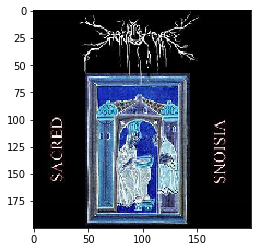

0
[0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
black


In [269]:
index = random.randrange(0,10,1)
demo_image = images[index]
plt.imshow(demo_image/255)
plt.show()
print(genre_mapping[truth[index]])

# Get the explanation (kinda slow)

In [265]:
explainer = lime_image.LimeImageExplainer()
#%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(demo_image, model.predict, top_labels=2, hide_color=0, num_samples=1000)
from skimage.segmentation import mark_boundaries

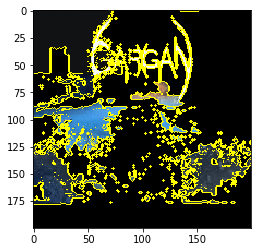

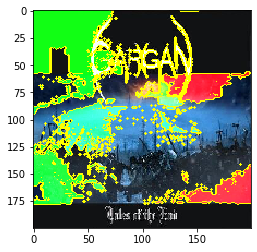

In [268]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
plt.imshow(demo_image/255)
plt.imshow(mark_boundaries(temp/255, mask))
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.imshow(demo_image/255)
plt.imshow(mark_boundaries(temp/255, mask))
plt.show()

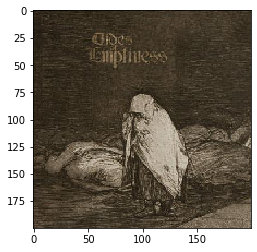

sorry bro, i thought this was death


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


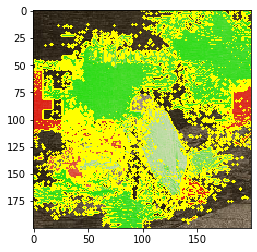

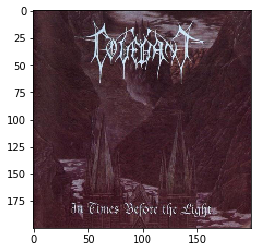

sorry bro, i thought this was death


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


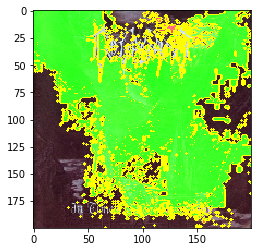

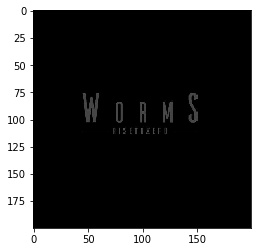

sorry bro, i thought this was black


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


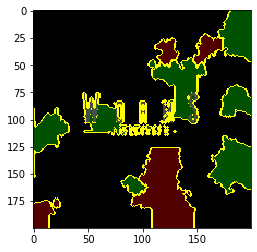

In [259]:
wrong_images = transform_img_fn(wrong_preds)
for i in range(len(wrong_images)):
    img = wrong_images[i]
    print('\n\nsorry bro, i thought this was {} metal'.format(genre_mapping[wrong_classes[i][0]]))
    plt.imshow(img/255)
    plt.show()
    explanation = explainer.explain_instance(img, model.predict, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
    print('and here\' why!')
    plt.imshow(img/255)
    plt.imshow(mark_boundaries(temp/255, mask))
    plt.show()




i got it right i said this was black metal


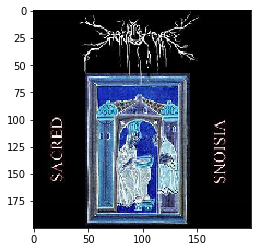

here's how i knew


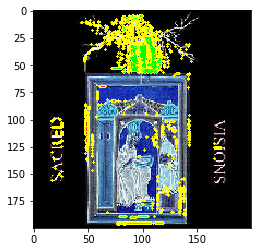



i got it right i said this was death metal


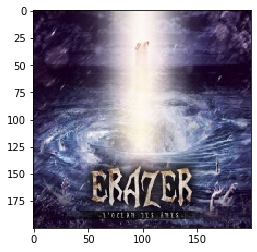

here's how i knew


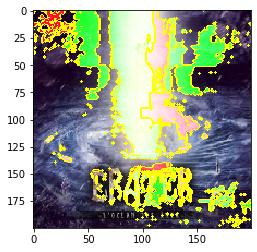



i got it right i said this was black metal


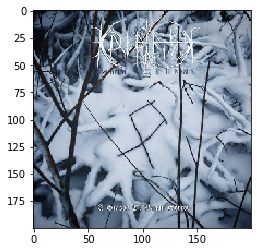

here's how i knew


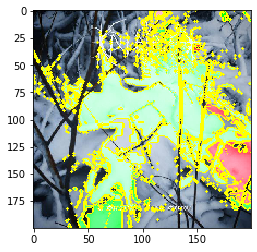



i got it right i said this was death metal


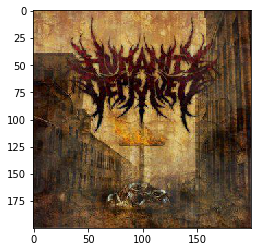

here's how i knew


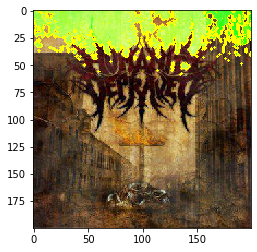



i got it right i said this was black metal


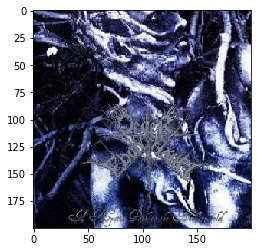

here's how i knew


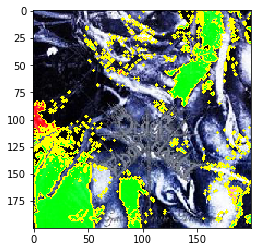



i got it right i said this was death metal


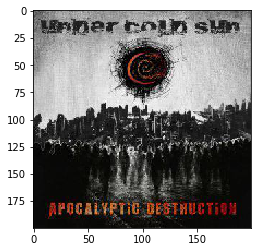

here's how i knew


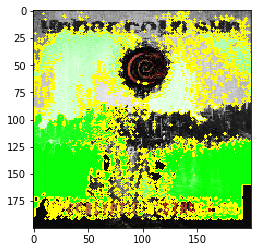



i got it right i said this was death metal


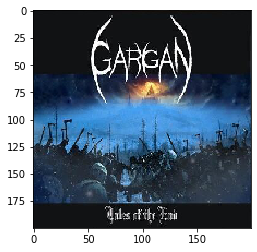

here's how i knew


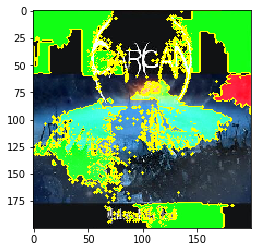

In [262]:
right_images = transform_img_fn(right_preds)
for i in range(len(right_images)):
    print('\n\ni got it right i said this was {} metal'.format(genre_mapping[right_classes[i][0]]))
    img = right_images[i]
    plt.imshow(img/255)
    plt.show()
    explanation = explainer.explain_instance(img, model.predict, top_labels=2, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
    print('here\'s how i knew')
    plt.imshow(img/255)
    plt.imshow(mark_boundaries(temp/255, mask))
    plt.show()
